# DC Resistivity Part 2

**Author:** [Lindsey Heagy](https://github.com/lheagy)

This example examines the distribution of charges and the behaviour of currents for a DC experiment where one end of an electrode is connected to a finite length well (follows [Kaufman (1993)](https://doi.org/10.1190/1.1443388). This notebook was used to produce Figure 6 in Heagy and Oldenburg (2018)

If you encounter problems when running this notebook, please [open an issue](https://github.com/simpeg-research/heagy_2018_emcyl/issues). 

## Setup and Software environment

The requirements to run this example are in [requirements.txt](../requirements.txt). Uncomment the following cell if you need to install them. 

In [49]:
# !pip install -r ../requirements.txt

In [1]:
import discretize
from discretize import utils
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.constants import mu_0
import ipywidgets

from SimPEG.EM import TDEM
from SimPEG import Utils, Maps

import casingSimulations as casingSim

from pymatsolver import Pardiso

%matplotlib inline

##  Parameters


In [2]:
simDir = 'DC_Kaufman_finite_well'  # create a simulation directory where results can be saved. 

In [3]:
casing_l = np.r_[250, 500, 1000, 2000, 4000]

### model parameters

In [4]:
sigma_back = 1e-2
casing_t = 10e-3 # 10mm thick casing
casing_d = 100e-3 # 10cm diameter

def get_model(casing_l):
    model = casingSim.model.CasingInHalfspace(
        directory = simDir,
        sigma_casing = 1e6,  # conductivity of the casing (S/m)
        sigma_back = sigma_back,  # conductivity of the background (S/m)
        sigma_inside = sigma_back,  # fluid inside the well has same conductivity as the background
        casing_d = casing_d-casing_t,  # 135mm is outer casing diameter
        casing_l = casing_l,
        casing_t = casing_t, 
    )

    # adjust the src_a location so it is connected to well
    model.src_a = np.r_[model.casing_r, np.pi/2., -1.25] 
    model.src_b = np.r_[2*casing_l.max(), np.pi/2., -1.25]
    
    return model

In [5]:
model_dict = {}
model_names = []
for l in casing_l:
    mod = get_model(l)
    name = "model_{}".format(l)
    model_names += [name]
    model_dict[name] = mod
model_dict

{'model_1000': <casingSimulations.model.CasingInHalfspace at 0x104799ed0>,
 'model_2000': <casingSimulations.model.CasingInHalfspace at 0x104799d10>,
 'model_250': <casingSimulations.model.CasingInHalfspace at 0x10feccc10>,
 'model_4000': <casingSimulations.model.CasingInHalfspace at 0x104799ad0>,
 'model_500': <casingSimulations.model.CasingInHalfspace at 0x104de7c90>}

## Mesh

Here we set up a 3D cylindrical mesh, discretizing in $x$, $\theta$ and $z$. 

To discretize in x, we start by defining the finest region of the mesh, ensuring that we have 4 cells across the thickness of the casing. From there, we expand the cell sizes until we reach the second uniform cell size we want to model at (`csx2`). We then use a constant cell spacing of `csx2` until we have meshed out to the end of the domain in which we want to examine data (`domainx2`). Beyond that, we add padding cells to *"infinity"*

In [6]:
# parameters defining the core region of the mesh
# note that the finest re
csx2 = 25.  # cell size in the x-direction in the second uniform region of the mesh (where we measure data)
csz = 2.5  # cell size in the z-direction 
domainx2 = 100  # go out 500m from the well

# padding parameters
npadx, npadz = 16, 23  # number of padding cells
pfx2 = 1.4  # expansion factor for the padding to infinity in the x-direction
pfz = 1.4


# theta discretization
hy = utils.meshTensor([(1, 2, -1.5), (1, 3), (1, 2, 1.5)])
hy = np.r_[hy, hy]
hy = hy*2*np.pi / hy.sum()


# set up a mesh generator which will build a mesh based on the provided parameters
# and casing geometry
def get_mesh(mod):
    return casingSim.CasingMeshGenerator(
        directory=simDir,  # directory where we can save things
        modelParameters=mod,  # casing parameters
        npadx=npadx,  # number of padding cells in the x-direction
        npadz=npadz,  # number of padding cells in the z-direction
        domain_x=domainx2,  # extent of the second uniform region of the mesh 
        hy=hy,   # cell spacings in the 
        csx1=mod.casing_t/4.,  # use at least 4 cells per across the thickness of the casing
        csx2=csx2,  # second core cell size
        csz=csz,  # cell size in the z-direction
        pfx2=pfx2,  # padding factor to "infinity"
        pfz=pfz  # padding factor to "infinity" for the z-direction
    )

In [7]:
mesh_dict = {
    key: get_mesh(mod) for key, mod in model_dict.iteritems()
}

[[<matplotlib.axes._subplots.PolarAxesSubplot at 0x10fecced0>,

/anaconda/lib/python2.7/site-packages/matplotlib/projections/polar.py:58: RuntimeWarning: invalid value encountered in less
  mask = r < 0


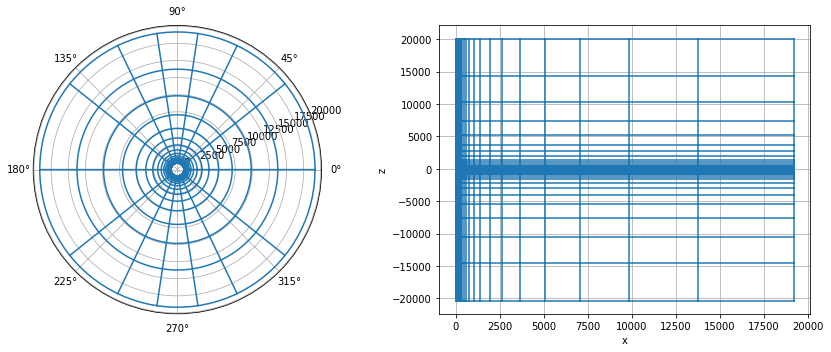

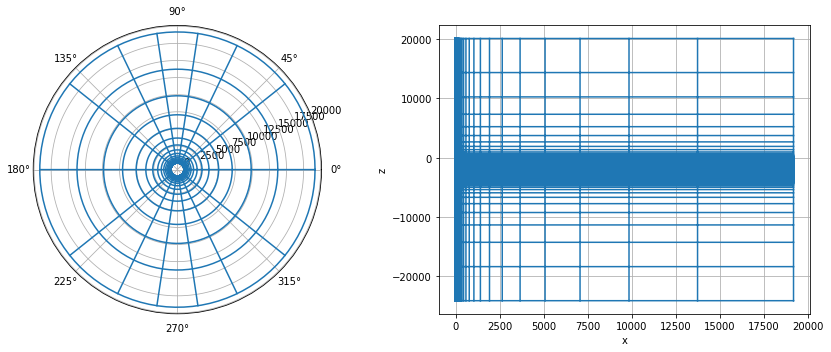

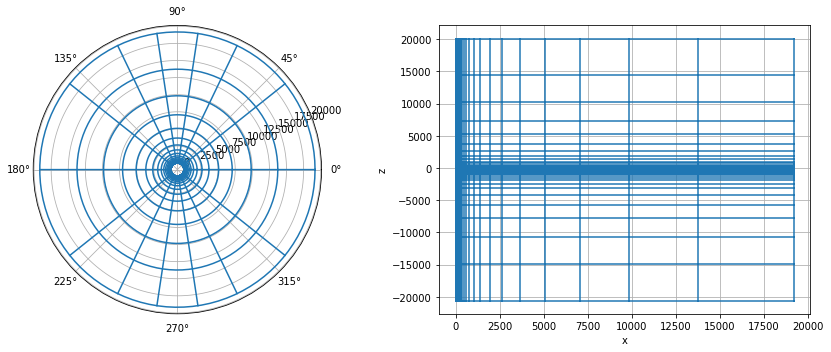

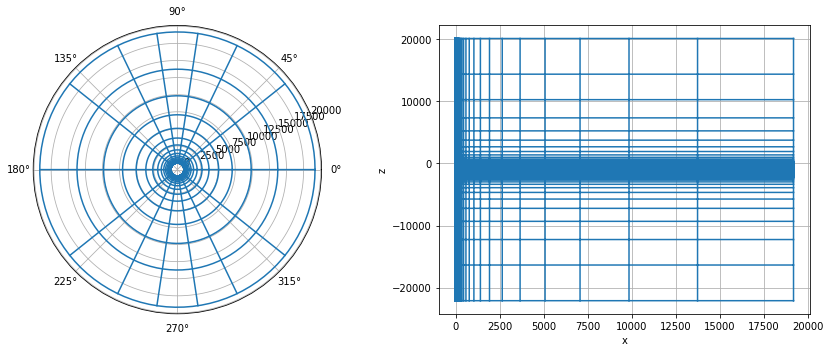

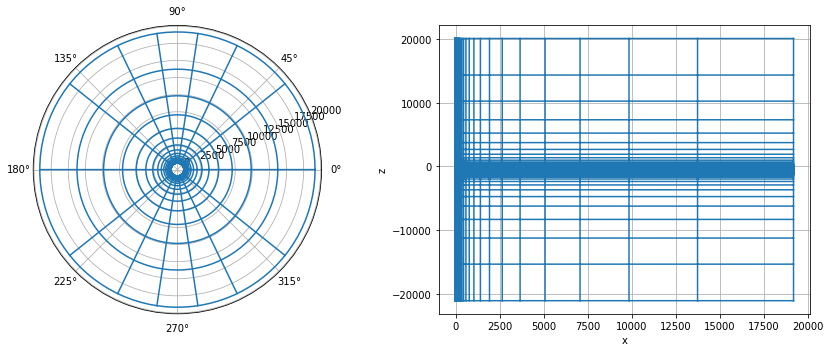

In [8]:
[meshGen.mesh.plotGrid() for meshGen in mesh_dict.values()]

In [9]:
mesh = mesh_dict[model_names[0]].mesh

In [30]:
for meshGen in mesh_dict.values():
    print(meshGen.mesh.nC)

168168
1785168
275968
922768
491568


## Physical property models

Now that we have defined the mesh and model parameters, we can populate the mesh with physical properties. 

In [33]:
# Assign physical properties on the mesh
physpropsDict = {
    name: casingSim.model.PhysicalProperties(mesh_dict[name], mod) 
    for name, mod in model_dict.iteritems()
}

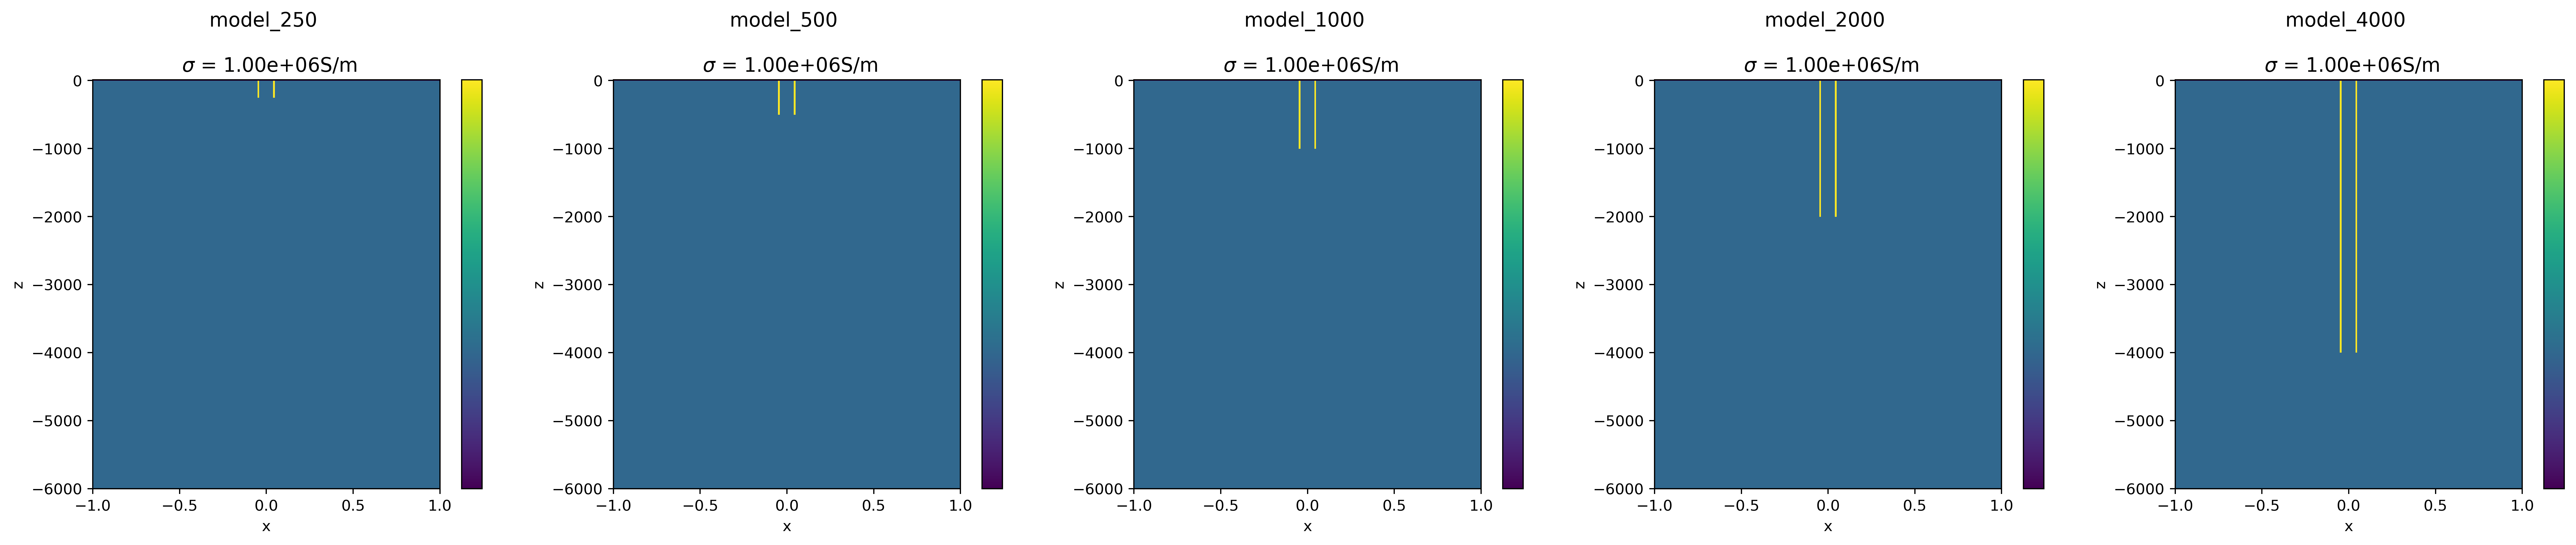

In [34]:
# Plot the models
xlim = np.r_[-1, 1]  # x-limits in meters
zlim = np.r_[-1.5*np.max(casing_l), 10.]  # z-limits in meters. (z-positive up)

fig, ax = plt.subplots(1, len(model_names), figsize=(6*len(model_names), 5), dpi=350)
if len(model_names) == 1:
    ax = [ax]
    
for a, title in zip(ax, model_names):
    pp = physpropsDict[title]
    pp.plot_sigma(
        ax=a, 
        pcolorOpts={'norm':LogNorm()}  # plot on a log-scale
    )
    a.set_title('{} \n\n $\sigma$ = {:1.2e}S/m'.format(title, pp.modelParameters.sigma_casing), fontsize=13)
#     cylMeshGen.mesh.plotGrid(ax=a, slice='theta') # uncomment to plot the mesh on top of this
    a.set_xlim(xlim)
    a.set_ylim(zlim)

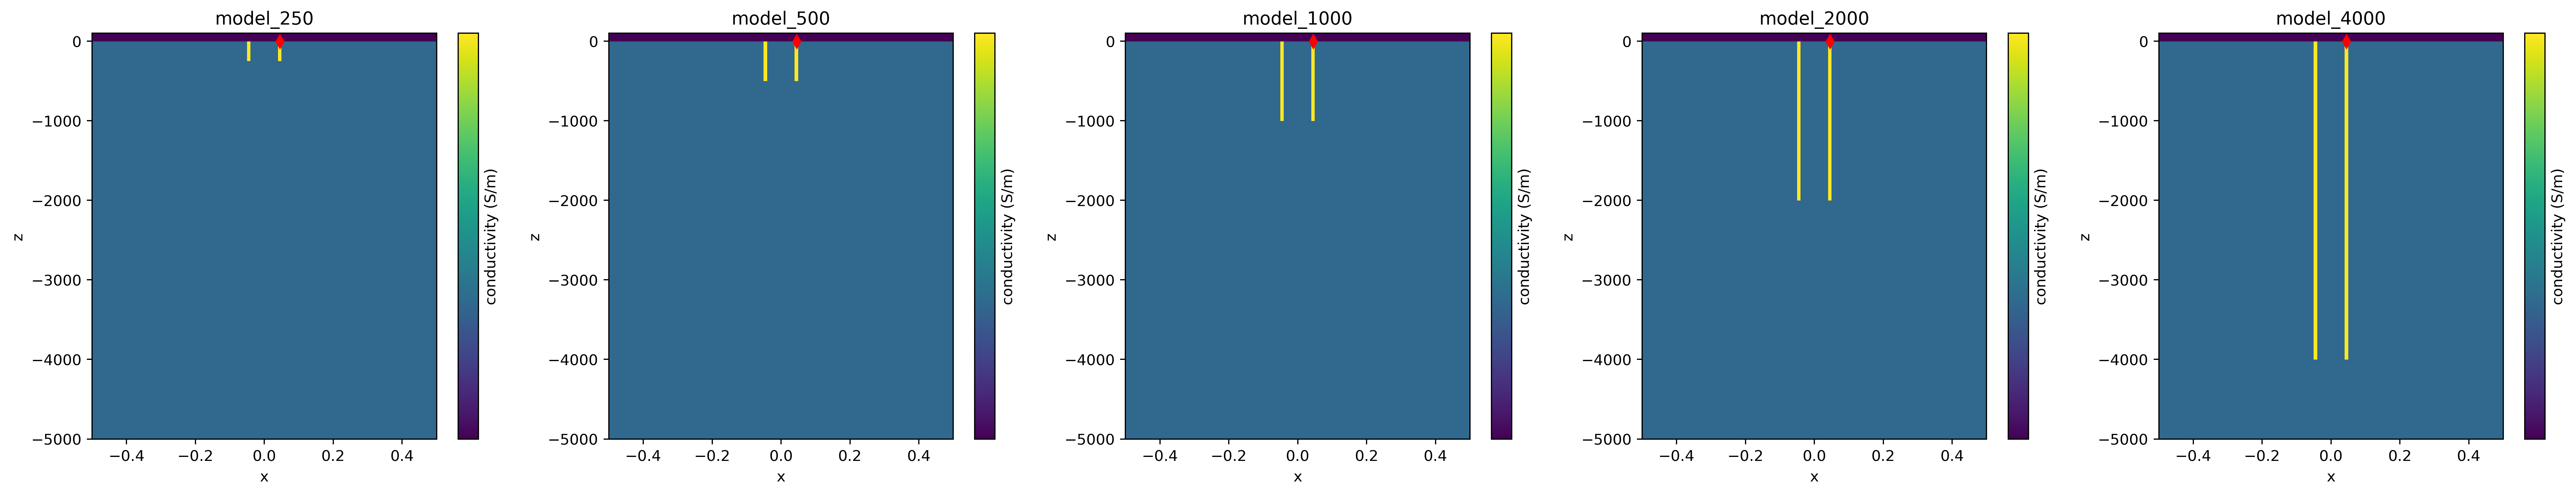

In [35]:
# Plot the source location

symbols = ['rd', 'ws', 'k>', 'mo', 'c*', 'C3s']

fig, ax = plt.subplots(1, len(model_names), figsize=(6*len(model_names), 5), dpi=350)

for key, a in zip(model_names, ax):
    # cylMeshGen.mesh.plotGrid(ax=ax, slice='theta')
    a, cb = physpropsDict[key].plot_sigma(
        ax=a, 
        pcolorOpts={'norm':LogNorm()}  # plot on a log-scale
    )

    cb.set_label('conductivity (S/m)')

    a.set_title(key)

    model = model_dict[key]
    a.plot(model.src_a[0], model.src_a[2], symbols[0])
    a.plot(model.src_b[0], model.src_b[2], symbols[0])

    a.set_xlim(0.5*np.r_[-1, 1]) #src_b[:, 0].max()])
    a.set_ylim([ -1.25*casing_l.max(), 100])


## set up a DC simulation

In [36]:
simDict = {}
for key in model_names:
    simDict[key] = casingSim.run.SimulationDC(
        modelParameters=model_dict[key], directory=simDir, 
        meshGenerator=mesh_dict[key], 
        src_a=model_dict[key].src_a, src_b=model_dict[key].src_b
    )


Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.


## Run the DC simulation

In [38]:
import time

In [39]:
%%time
fieldsDict = {}
for title in model_names:
    print('--- Running {} ---'.format(title))
    fieldsDict[title] = simDict[title].run()
    print('\n')

--- Running model_250 ---
Validating parameters...
      max x: 19169.5917058, min z: -20342.4981276, max z: 20092.4981276, nC: 168168
Saved DC_Kaufman_finite_well/simulationParameters.json
Starting SimulationDC
Using <class 'pymatsolver.direct.Pardiso'> Solver
   ... Done. Elapsed time : 5.17080307007


--- Running model_500 ---
Validating parameters...
      max x: 19169.5917058, min z: -20592.4981276, max z: 20092.4981276, nC: 275968
Saved DC_Kaufman_finite_well/simulationParameters.json
Starting SimulationDC
Using <class 'pymatsolver.direct.Pardiso'> Solver
   ... Done. Elapsed time : 11.1268010139


--- Running model_1000 ---
Validating parameters...
      max x: 19169.5917058, min z: -21092.4981276, max z: 20092.4981276, nC: 491568
Saved DC_Kaufman_finite_well/simulationParameters.json
Starting SimulationDC
Using <class 'pymatsolver.direct.Pardiso'> Solver
   ... Done. Elapsed time : 25.1549589634


--- Running model_2000 ---
Validating parameters...
      max x: 19169.5917058, m

## Plot the casing currents

In [40]:
key = model_names[0]
src_ind=0
f = fieldsDict[key]
src = simDict[key].survey.srcList[src_ind]
mod = model_dict[key]
mesh = mesh_dict[key].mesh
ix, iz = casingSim.physics.CasingCurrents(
    f[src, 'j'], mesh,  
    mod.casing_a, 
    mod.casing_b, mod.casing_z,
)

charges = utils.mkvc(f[src, 'charge'])
#         charges = charges 
charges[not mod.ind_casing]  = 0.
charges = charges.reshape(mesh.vnC, order='F').sum(0).sum(0)

In [41]:
~mod.ind_casing(mesh)

array([ True,  True,  True, ...,  True,  True,  True])

In [42]:
# from equations 45 and 53 in Kaufman and Wightman (1993)
def current_short_well(model, z):
    return (1 - z/model.casing_l)

def current_long_well(model, z):
    alpha = 1./np.sqrt(
        1./model.sigma_back * model.sigma_casing * 2. * np.pi * model.casing_r * model.casing_t
    )
    print(alpha)
    return np.exp(-alpha * z)

In [43]:
# plot currents in casing

epsilon = 1e-16
src_ind=0

def plot_casing_currents(ax=None, include_transmission=True):
   
    if ax is None: 
        fig, ax = plt.subplots(1, 2, figsize=(10, 4)) #, dpi=400)
#     ax = [ax
    
    for i, key in enumerate(model_names):
        f = fieldsDict[key]
        src = simDict[key].survey.srcList[src_ind]
        mod = model_dict[key]
        mesh = mesh_dict[key].mesh
        ix, iz = casingSim.physics.CasingCurrents(
            f[src, 'j'], mesh,  
            mod.casing_a, 
            mod.casing_b, mod.casing_z,
        )
        
        charges = utils.mkvc(f[src, 'charge'])
#         charges = charges 
        charges[~mod.ind_casing(mesh)] = 0.
        charges = charges.reshape(mesh.vnC, order='F').sum(0).sum(0)
        
        label = key.split("_")[-1] + " m"
        
        x0 = -mesh.vectorNz/mod.casing_l
        x0_inds = (x0 > 0) & (x0 < 1)
        x1 = -mesh.vectorCCz/mod.casing_l
        
        ax[0].plot(
            x0[x0_inds], -iz[x0_inds], 
            label=label, color="C{}".format(i)
        )
        ax[1].plot(
            x1[(x1 > 0) & (x1 < 1)], charges[(x1 > 0) & (x1 < 1)], 
            label=label, color="C{}".format(i)
        )
        
        if include_transmission is True:
            if mod.casing_l == casing_l.min():
                short_well = current_short_well(mod, -mesh.vectorNz[x0_inds])
                ax[0].plot(
                    x0[x0_inds], short_well, 
                    color="k", linestyle='--'
                )
            elif mod.casing_l == casing_l.max():
                long_well = current_long_well(mod, -mesh.vectorNz[x0_inds])
                ax[0].plot(
                    x0[x0_inds], long_well, 
                    color="k".format(i), linestyle='-.'
                )

    [a.set_xlim([1.25/mod.casing_l, 1.]) for a in ax]
    [a.legend() for a in ax]
    [a.set_xlabel('depth / casing length') for a in ax]
    [a.grid(which='both', alpha=0.4) for a in ax]
#     ax[0].set_ylabel('Electric Field (V/m)')    

#     ax[1].legend()
#     ax[1].set_ylabel('percent difference')

    ax[0].set_ylabel('Downward-going Current (A)')
    ax[1].set_ylabel('Charges (C)')
    
    
    
#     ax[0].set_title(src_names[src_ind] + ' source \n\n Vertical Current in Casing')
    
    
#     plt.tight_layout()
#     plt.show()
    
    return ax

0.0018806319451591875


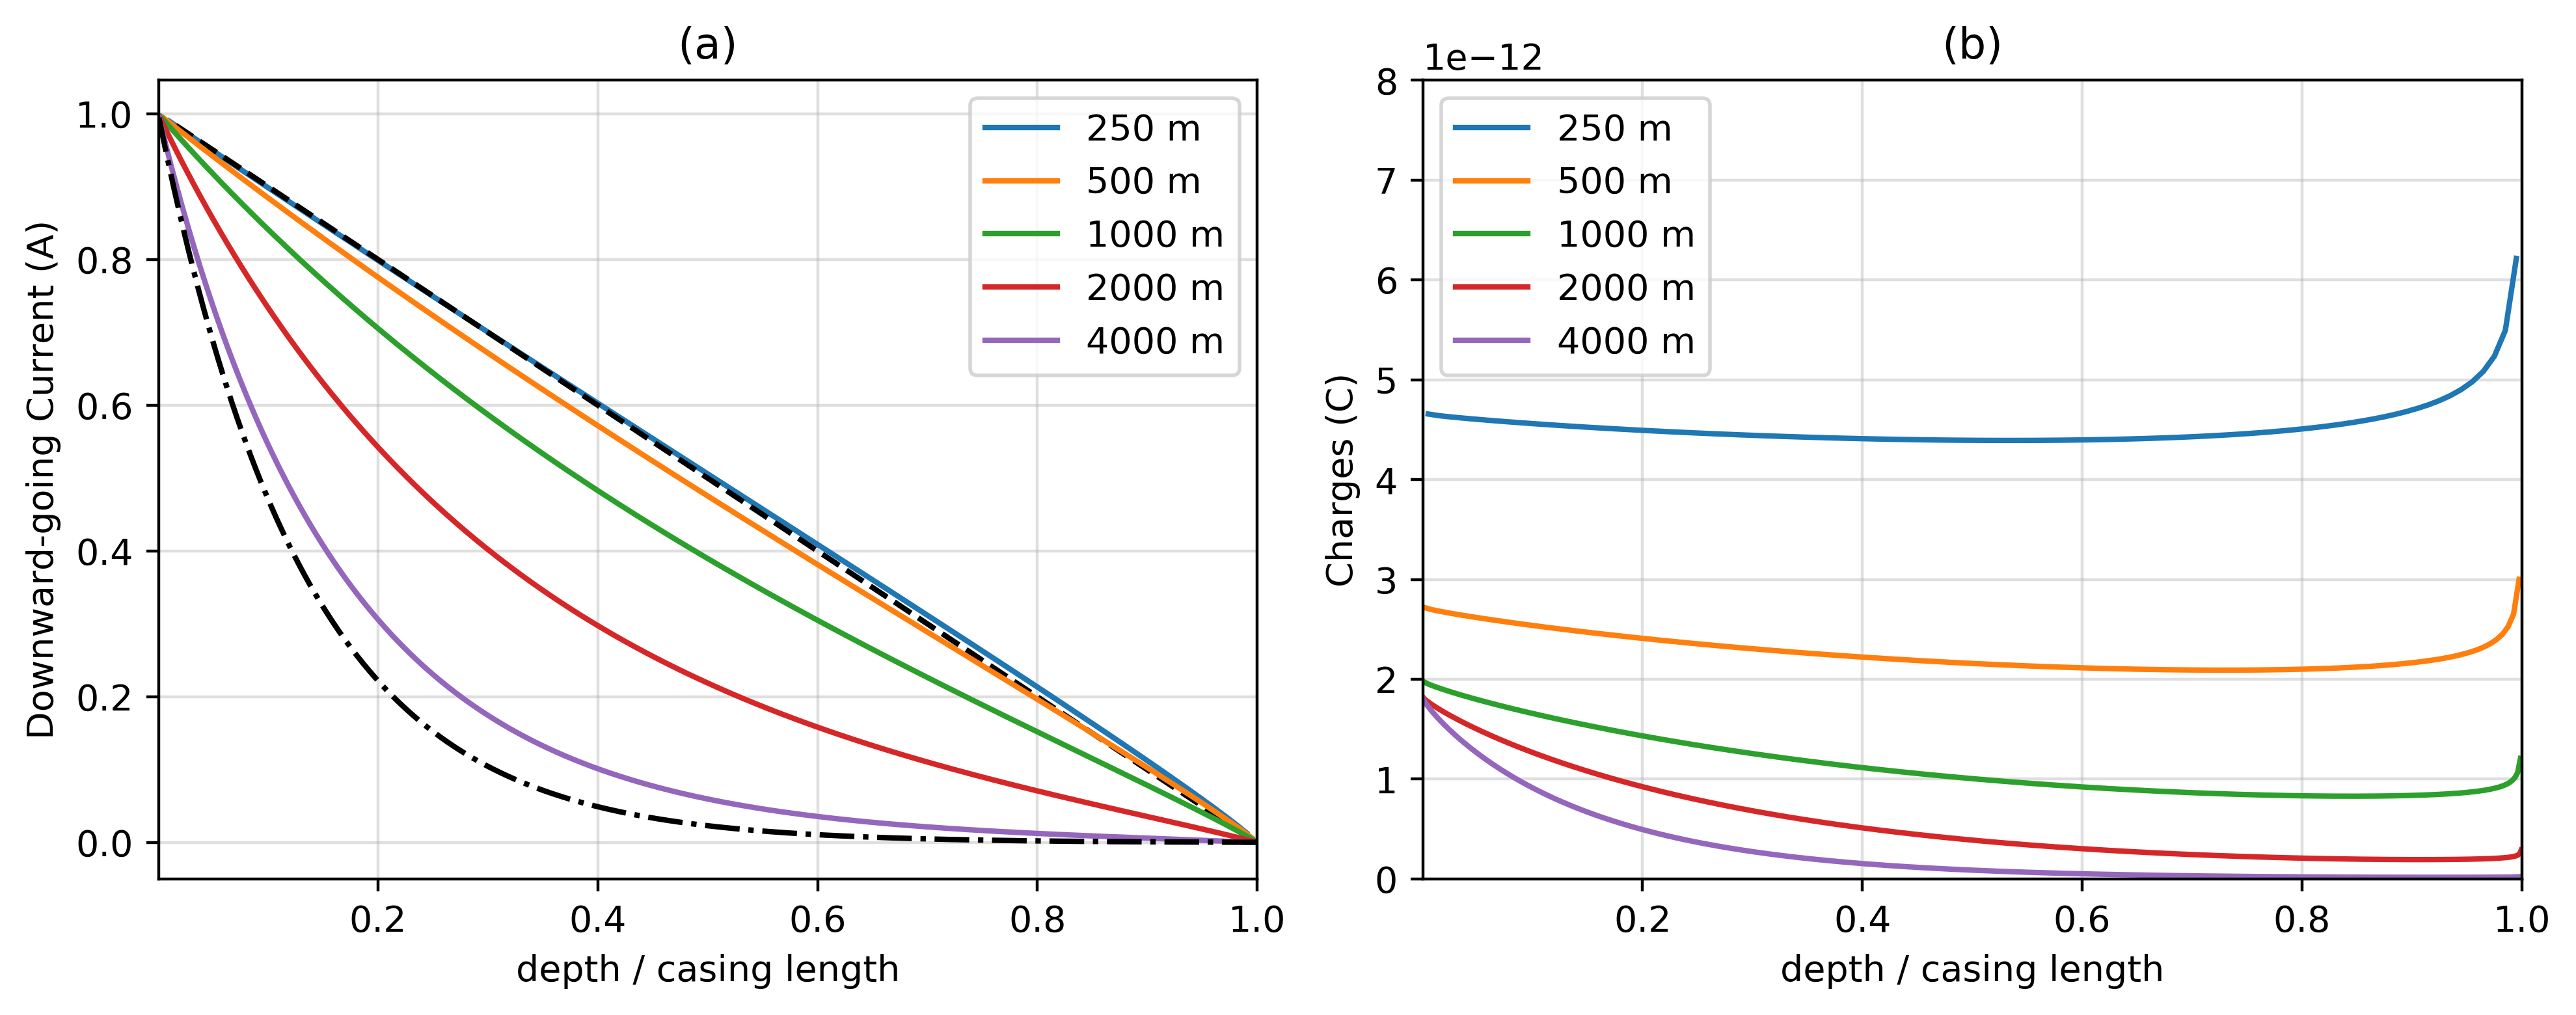

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=400)
ax = plot_casing_currents(ax=ax)
ax[1].set_ylim(8e-12*np.r_[0, 1])

ax[0].set_title('(a)')
ax[1].set_title('(b)')

plt.tight_layout()

# fig.savefig("kaufman_finite_well")  # uncomment to save the figure

## Plotting code for the fields, fluxes and charges

In [45]:
# Plot the charges
src_ind=0

background_key = 'background'

def plotCasingResults(
    ax = None,
    clim_max=None, clim_min=None, 
    max_depth=1.1*model.casing_l, 
    max_r=0.1, top=10., view='charge', model=model_names[0], 
    primsec=['total'], #, 'primary', 'secondary'], 
    casing_outline=True, 
    theta_ind=0
):
    mesh2D = mesh_dict[model].create_2D_mesh().mesh
    
    if ax is None: 
        plt.subplots(1, 1, figsize=(5, 6))
        
    assert view.lower() in ['charge', 'phi', 'j', 'e']

    xlim = max_r*np.r_[-1, 1]  # x-limits in meters
    zlim = np.r_[-max_depth, top]  # z-limits in meters. (z-positive up)
    
    clim = None
    plotopts = {
        'theta_ind': theta_ind,
    }
    
    if not clim_max is not None or clim_max != 0.:
        clim = clim_max * np.r_[-1, 1]
        plotopts['clim'] = clim

        if clim_min is not None or clim_min != 0.:
            plotopts['clim'][0] = clim_min
        
    if primsec == 'primary':
        model = background_key

    pp = physpropsDict[model]
    src = simDict[model].survey.srcList[src_ind]
    plotme = simDict[model].fields()[src, view]
    
    if primsec == 'secondary':
        prim_src = simDict[background_key].survey.srcList[src_ind]
        plotme = plotme - simDict[background_key].fields()[prim_src, view]

    if view in ['charge', 'phi']:
        _, cb = pp.plot_prop(
            plotme,
            ax=ax,
            pcolorOpts = {'cmap': 'bwr' if view == 'charge' else 'viridis'},
            **plotopts 
        )
    elif view in ['j', 'e']:
        jplt = casingSim.face3DthetaSlice(
            mesh_dict[model].mesh, plotme, theta_ind=theta_ind
        )
        mirror_data = casingSim.face3DthetaSlice(
            mesh_dict[model].mesh, plotme, theta_ind=theta_ind + 7
        )
    
        _, cb = casingSim.plotFace2D(
            mesh2D,
            jplt, real_or_imag='real', ax=ax, range_x=xlim,
            range_y=zlim, sample_grid=np.r_[np.diff(xlim)/100., np.diff(zlim)/100.],
            logScale=True, clim=clim, mirror=True, mirror_data=mirror_data
        )
    ax.set_title('{} {}'.format(primsec, view), fontsize=13)
    #     cylMeshGen.mesh.plotGrid(ax=a, slice='theta') # uncomment to plot the mesh on top of this
    ax.set_xlim(xlim)
    ax.set_ylim(zlim)
#         cb.set_label(view)
        
    # plot outline of casing
    if casing_outline is True: 
        m = model_dict[model]
        factor = [-1, 1]
        [
            ax.plot(
                fact * np.r_[m.casing_a, m.casing_a, m.casing_b, m.casing_b, m.casing_a],
                np.r_[m.casing_z[1], m.casing_z[0], m.casing_z[0], m.casing_z[1], m.casing_z[1]],
                'k', 
                lw = 0.5
            ) 
            for fact in factor
        ]
    return ax 
    

def plotCasingResultsWidget(
    clim_max=None, clim_min=None, 
    max_depth=1.1*model.casing_l, 
    max_r=0.1, top=10., view='charge', model='all', 
    primsec=['total', 'primary', 'secondary'], 
    theta_ind=0
):
    
    model_names = model_names if model == 'all' else [model]
    
    fig, ax = plt.subplots(1, len(model_names), figsize=(len(model_names)*5, 6))
    if len(model_names) == 1:
        ax = [ax]
    
    for a, mod in zip(ax, model_names): 
        a = plotCasingResults(
            ax = a,
            clim_max=clim_max, clim_min=clim_min, 
            max_depth=max_depth, 
            max_r=max_r, top=top, view=view, model=mod, 
            primsec=primsec, 
            casing_outline=True, 
            theta_ind=theta_ind
        )
    
    plt.tight_layout()
    plt.show()

### Widget for viewing Results

The widgets available to you are
- **theta_ind**: [0, ntheta slices] Which azimuth should we slice through
- **clim_max**: max value on the colorbar so you can saturate it
- **max_depth**: max z-limit for the plot
- **top**: top of the plot (z)

observations:
- (sanity checks): in all charges at interface between casing and formation. All positive charges (positive electrode connected to casing
- charge distribution more uniform along length of casing for solid steel (also makes sense: better conductor)

In [46]:
# fig, ax = plt.subplots(1, 3, figsize=(18, 5), dpi=350)

ipywidgets.interact(
    plotCasingResultsWidget,
    clim_max = ipywidgets.FloatText(value=0),
    clim_min = ipywidgets.FloatText(value=0),
    max_depth = ipywidgets.FloatText(value=casing_l.max()), 
    max_r = ipywidgets.FloatText(value=0.1),
    top = ipywidgets.FloatText(value=0),
    view = ipywidgets.ToggleButtons(
        options=['charge', 'phi', 'j', 'e'], value='charge'
    ),
    model = ipywidgets.ToggleButtons(
        options=model_names + ['all'], value=model_names[0]
    ),
    primsec = ipywidgets.ToggleButtons(
        options=['total'], value='total'
    ), 
    theta_ind = ipywidgets.IntSlider(min=0, max=len(mesh_dict[model_names[0]].hy)-1)
)   

<function __main__.plotCasingResultsWidget>

### Total charge on the casing

- integrate the charge on the casing. 